<h2> Skin Cancer Kaggle challenge </h2>
<p>https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000</p>
<p> Dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). </p>

In [21]:
import cv2
import matplotlib.pyplot as plt

In [22]:
!ls archive

HAM10000_images_part_1 hmnist_28_28_L.csv     hmnist_8_8_RGB.csv
HAM10000_images_part_2 hmnist_28_28_RGB.csv
HAM10000_metadata.csv  hmnist_8_8_L.csv


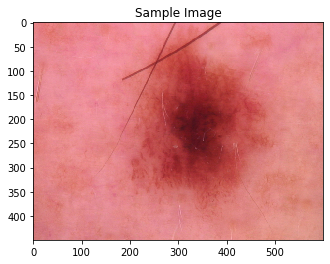

In [23]:
# https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading

img = cv2.imread('archive/HAM10000_images_part_1/ISIC_0024306.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.title('Sample Image')
plt.show()